In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from riskyneuroarousal.utils.load_data import (load_behavioral_data, load_pupil_data, load_ddm_results)
from scipy.stats import false_discovery_control
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [10]:
behavior = load_behavioral_data(min_RT = 0.2)
pupil_data = load_pupil_data()
data = pupil_data.merge(behavior, on=["sub", "trial"])
data["pupil_size"] = data["ps_preprocessed"] - data["baseline"]

In [11]:
ddm_results = load_ddm_results()
model_per_sub = ddm_results.loc[ddm_results.query("param_name == 'BIC'").groupby("sub")[["mean"]].idxmin()["mean"].values][["sub", "model_ID"]]
model_per_sub = model_per_sub.merge(ddm_results, on=["sub", "model_ID"])
starting_point = model_per_sub.query("param_name == 'z'")[["mean", "sub"]]
starting_point = starting_point.rename(columns={"mean": "starting_point"})

In [12]:
data["loss_gain"] = np.log(data["loss"] / data["gain"])
data = data.merge(starting_point, on="sub")

In [13]:
%%R -i data
library(mgcv)
library(lme4)
library(lmerTest)
library(broom.mixed)

Loading required package: nlme
This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.
Loading required package: Matrix

Attaching package: ‘lme4’

The following object is masked from ‘package:nlme’:

    lmList


Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



First, we examine if there are differences in the interaction. 

In [14]:
%%R -o results
# loop through timebins
results <- data.frame()
for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    model = lmer(pupil_size ~ loss_gain*condition*starting_point + RT*condition + blink*condition + (1 | sub), data=data[data$timebin == tb, ])
    # Gather results
    model_result <- tidy(model, effects = "fixed", conf.int = TRUE, conf.level = 0.95) 
    model_result$timebin <- tb
    # Append results
    results <- rbind(results, model_result)
}

In [15]:
results["p.value"] = false_discovery_control(results["p.value"], method = "by")
results = results.rename(columns={"p.value": "p_value"})

In [16]:
# From this, all I want to look is at the pvalues that are significant
results = results.query("p_value < 0.05 & term.str.contains('conditionequalRange')")

In [18]:
%%R -o results_individual
# loop through timebins
results_individual <- data.frame()
for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    modelIndifference = lmer(pupil_size ~ loss_gain*starting_point + RT + blink + (1 | sub), data=data[data$timebin == tb & data$condition == 'equalIndifference', ])
    modelRange = lmer(pupil_size ~ loss_gain*starting_point + blink + RT + (1 | sub), data=data[data$timebin == tb & data$condition == 'equalRange', ])
    # Gather results
    resultsIndifference <- tidy(modelIndifference, effects = "fixed", conf.int = TRUE, conf.level = 0.95) 
    resultsRange <- tidy(modelRange, effects = "fixed", conf.int = TRUE, conf.level = 0.95)
    resultsIndifference$condition <- 'equalIndifference'
    resultsRange$condition <- 'equalRange'
    resultsIndifference$timebin <- tb
    resultsRange$timebin <- tb
    # Append results
    results_individual <- rbind(results_individual, resultsIndifference)
    results_individual <- rbind(results_individual, resultsRange)
}

In [19]:
results_individual["p.value"] = false_discovery_control(results_individual["p.value"], method = "by")
results_individual = results_individual.rename(columns={"p.value": "p_value"})

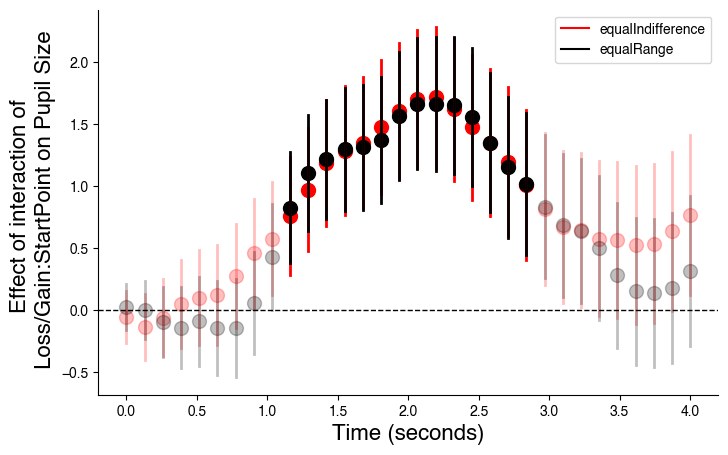

In [24]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 5))
grouped_df = results_individual.query("term == 'loss_gain:starting_point'").sort_values(["timebin", "condition"]).reset_index(drop=True)

# For each timebin, plot the estimate of the gain effect for each condition. If the pvalue is not significant, alpha = 0.25
for i, row in grouped_df.iterrows():
    if row["p_value"] < 0.05:
        alpha = 1
    else:
        alpha = 0.25
    if row["condition"] == "equalIndifference":
        color = "red"
    elif row["condition"] == "equalRange":
        color = "black"
    ax.plot([row["timebin"], row["timebin"]], [row["conf.low"], row["conf.high"]], color=color, linewidth=2, alpha=alpha)
    ax.scatter(row["timebin"], row["estimate"], color=color, s=100, alpha=alpha)

ax.plot([], [], color = "red", label="equalIndifference")
ax.plot([], [], color = "black", label="equalRange")
ax.set_xlabel("Time (seconds)", fontsize=16)
ax.set_ylabel("Effect of interaction of \n Loss/Gain:StartPoint on Pupil Size", fontsize=16)
# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)
# Add horizontal line at y=0
ax.axhline(0, color="black", linestyle="--", linewidth=1)
# Add legend where red is equalIndifference and black is equalRange
plt.legend()
# if loss_gain_timebin.shape[0] > 0:
#     ax.axvspan(min(loss_gain_timebin), max(loss_gain_timebin), color="red", alpha=0.1)
# plt.ylim(-0.02, 0.025)
plt.show()

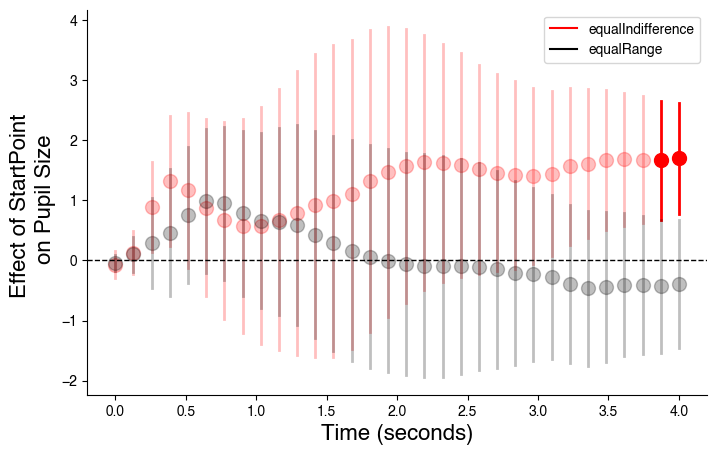

In [25]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 5))
grouped_df = results_individual.query("term == 'starting_point'").sort_values(["timebin", "condition"]).reset_index(drop=True)

# For each timebin, plot the estimate of the gain effect for each condition. If the pvalue is not significant, alpha = 0.25
for i, row in grouped_df.iterrows():
    if row["p_value"] < 0.05:
        alpha = 1
    else:
        alpha = 0.25
    if row["condition"] == "equalIndifference":
        color = "red"
    elif row["condition"] == "equalRange":
        color = "black"
    ax.plot([row["timebin"], row["timebin"]], [row["conf.low"], row["conf.high"]], color=color, linewidth=2, alpha=alpha)
    ax.scatter(row["timebin"], row["estimate"], color=color, s=100, alpha=alpha)

ax.plot([], [], color = "red", label="equalIndifference")
ax.plot([], [], color = "black", label="equalRange")
ax.set_xlabel("Time (seconds)", fontsize=16)
ax.set_ylabel("Effect of StartPoint \n on Pupil Size", fontsize=16)
# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)
# Add horizontal line at y=0
ax.axhline(0, color="black", linestyle="--", linewidth=1)
# Add legend where red is equalIndifference and black is equalRange
plt.legend()
# if loss_gain_timebin.shape[0] > 0:
#     ax.axvspan(min(loss_gain_timebin), max(loss_gain_timebin), color="red", alpha=0.1)
# plt.ylim(-0.02, 0.025)
plt.show()